Stochastic Methods for Data Analysis, Inference and Optimization

## Problem 1: Monte Carlo Integration

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$
h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}
$$

Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:
- inverse transform sampling
- rejection sampling with both uniform proposal distribution and normal proposal distribution (steroids) (with appropriately chosen parameters)
- importance sampling with both uniform proposal distribution and normal proposal distribution (with appropriately chosen parameters)

# define pdf, cdf, incdf functions for $f_X(x)$


In [169]:
import numpy as np
import matplotlib.pyplot as plt
def h(x):
    val = np.exp(-(x-5)**2 / 18)/(3*np.sqrt(2)*np.pi)
    return val
def pdf1(x):
    a1 = (x >= 1) * (x<=3) * ((x-1)/12)
    a2 = (x >  3) * (x<=5) * (-(x-5)/12)
    a3 = (x >  5) * (x<=7) * ((x-5)/6)
    a4 = (x >  7) * (x<=9) * (-(x-9)/6)
    return (a1+a2+a3+a4)

def cdf1(x):
    a1 = (x >= 1) * (x<=3) * ((x-1)**2/24)
    a2 = (x >  3) * (x<=5) * (-(x-5)**2/24 + 1/6 + 1/6)
    a3 = (x >  5) * (x<=7) * ((x-5)**2/12  + 1/6 + 1/6)
    a4 = (x >  7) * (x<=9) * (-(x-9)**2/12 + 1/3 + 1/3 +1/6 + 1/6)
    a5 = (x >  9) * (1)
    return (a1+a2+a3+a4+a5)

def invCDF1(u):
    cd = (u >= 0) * (u <= 1/6)
    u1 = u * cd
    a1 = (np.sqrt(24*u1)+1)*cd
    
    cd = (u >1/6) * (u <= 2/6) 
    u2 = cd * u
    a2 = (-np.sqrt( 24*(2/6 - u2) )+5)*cd
    
    cd = (u >1/3) * (u <= 2/3) 
    u3 = cd * u
    a3 = (np.sqrt( 12*abs(u3-1/3) )+5)*cd
    
    
    cd = (u >2/3) * (u <= 1)
    u4 = cd * u
    a4 = (-np.sqrt( 12*(1-u4) ) + 9)*cd

    return (a1+a2+a3+a4)



# test if  $f_X(x)$, $F_X(x)$, and $F_X^{-1}(x)$ is defined correctly

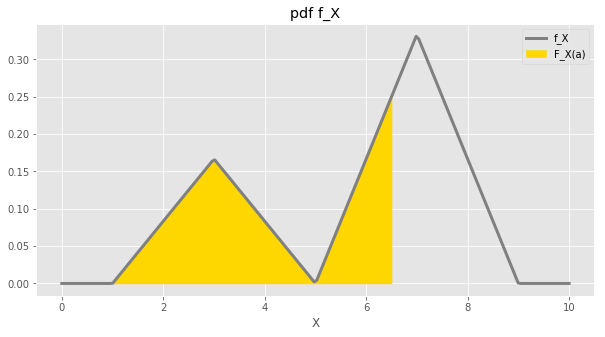

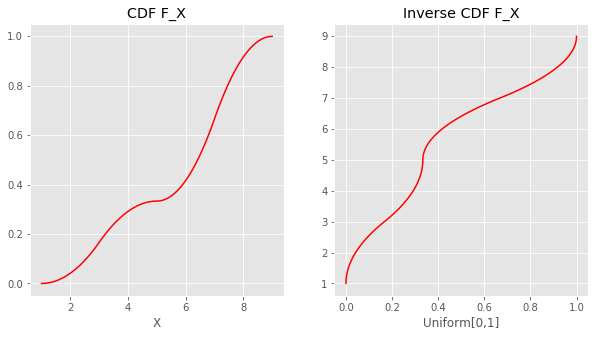

In [171]:
#visualize pdf and cdf
x = np.linspace(0, 10, 200)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, pdf1(x), color='gray', linewidth=3, label='f_X')

x = np.linspace(1, 6.5, 200)
ax.fill_between(x, pdf1(x), color='gold', label='F_X(a)')
ax.set_xlabel('X')
ax.set_title('pdf f_X')
ax.legend(loc='best')


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

cypt = cdf1(xpt)
ax1.plot(xpt,cypt,'r-')
ax1.set_xlabel('X')
ax1.set_title('CDF F_X')

invypt = invCDF1(cypt)
ax2.plot(cypt,invypt,'r-')
ax2.set_xlabel('Uniform[0,1]')
ax2.set_title('Inverse CDF F_X')

plt.show()

# use inverse transform to obtain sampels following $f_X(x)$ as density

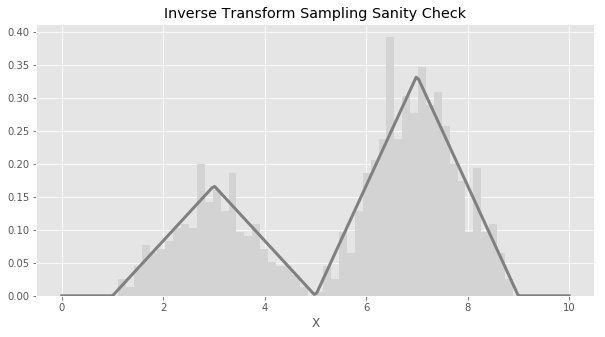

Inverse Transform estimate E[h(x)]: 0.058724203030662794


In [172]:
## inverse transform sampling
################################
def inverse_transform(h, invCDF1, n):

    #1. sample y-values uniformly from [0, 1]
    y = np.random.uniform(0, 1, n)

    #2. turn these y-values into x-values using the inverse CDF
    x_samples = invCDF1(y)

    #3. apply h to the x-values and average
    mean_inv = np.mean(h(x_samples))
    return x_samples, mean_inv


n_samples = 1000 #number of samples to draw

x_samples, mean_inv = inverse_transform(h, invCDF1, n_samples)

#Sanity check: make sure these x-values look like they 
#are from the correct distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, pdf1(x), color='gray', linewidth=3)
ax.hist(x_samples, bins=50, normed=1, color='lightgray', linewidth=0)
ax.set_xlabel('X')
ax.set_title('Inverse Transform Sampling Sanity Check')
plt.show()

print('Inverse Transform estimate E[h(x)]: {}'.format(mean_inv))

# Rejection Sampling
## Steps to set up rejection sampling
1. Propose a distribution $g(x)$, which is easy to sample from
1. Find a constant $M$ such that $f_X \leq M g$ 
1. Note steriod means $g(x)$ follows $N(\mu,\sigma^2)$, and we can also use uniform$[a,b]$ where a=1, b=9

Note:  we want $M$ to be as small as possible.
However, in this case we will simply pick a $M$ based on visualizations.

## steps to sample
1. Sample out $x_i$ using $g(x)$
1. Compute $M\times g(x_i)$
1. Sample out $u_i$ follows uniform[0,$Mg(x_i)$]
1. If $f_X(x_i) > u_i $, accept $x_i$
1. Say we want 100 samples, then we repeat the above until we get 100 samples
1. then plug in this 100 samples to h(x) and then compute its mean and this is $\mathbb{E}[h(X)]$


# importance sampling

Use the transform
$$ \mathbb{E}_X(h) = \int_1^9 h(x)f(x) dx = \int_1^9 \frac{h*f}{g} * g(x) dx = \mathbb{E}_g\left(\frac{h*f}{g} \right)
$$

Steps
1. sample $x_i$ from distribution g
2. compute $\frac{h*f}{g}(x_i)$
3. repeat n times (number of samples you want)
4. compute the mean which is $\mathbb{E}_X(h)$


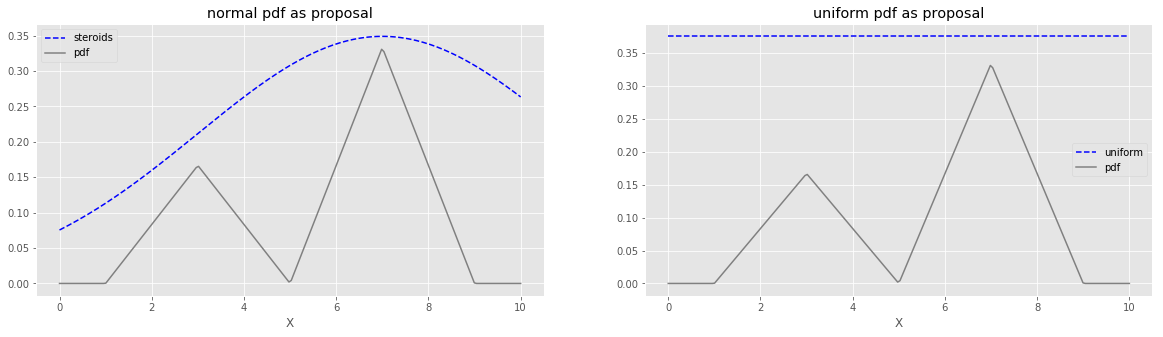

In [128]:
import scipy.stats as stats


xpt = np.linspace(0, 10, 200)
ypt = pdf1(xpt)

## Try different mu and sigma using Steroids
##################################################
mu    = 7
sigma = 4
M     = 3.5

# Try plot Mg(x) and ypt
gx  = stats.norm.pdf(xpt,loc = mu, scale = sigma)
Steroids = M*gx

## Try uniform pdf as proposal
##################################################
a , b = 1, 9
unif_y =np.array([1/(b-a)] *len(xpt))
M_y = 3

## plot uniform proposal and steroids proposal
##################################################
fig, (ax_norm, ax_unif) = plt.subplots(1, 2, figsize=(20, 5))
xpt = np.linspace(0, 10, 200)

ax_norm.plot(xpt, M*gx,'--', c='blue', label='steroids')
ax_norm.plot(xpt, ypt,'-',c = 'gray',  label='pdf')
ax_norm.set_xlabel('X')
ax_norm.set_title('normal pdf as proposal')
ax_norm.legend(loc='best')

ax_unif.plot(xpt, M_y*unif_y,'--', c='blue', label='uniform')
ax_unif.plot(xpt, ypt,'-',c = 'gray',  label='pdf')
ax_unif.set_xlabel('X')
ax_unif.set_title('uniform pdf as proposal')
ax_unif.legend(loc='best')
plt.show()



    

In [227]:
## setup uniform proposal and steroids proposal
##################################################
from functools import partial

def steroids_prop(mu, sigma,n_samples = None,x = None):
    if(n_samples != None):
        return np.random.normal(loc = mu, scale = sigma, size = n_samples)
    elif(len(x) > 0 ):
        return stats.norm.pdf(x, loc = mu, scale = sigma)
    else:
        return None

steroids = partial(steroids_prop, mu = mu, sigma = sigma)

steroids_prop
def unif_prop(a, b,n_samples = None,x = None):
    if(n_samples != None):
        return np.random.uniform(a,b,n_samples)
    elif(len(x)!=0):
        return np.array([1/(b-a)] * len(x))
    else:
        return None

unif = partial(unif_prop,a = a, b = b)
## define rejection 
##################################################
def rejection(prop_pdf, prop_M, true_pdf, n_samples, h,lhs=1,rhs=9):
    accept = np.zeros(n_samples)
    ai     = 0
    total  = 0
    
    while(ai < n_samples):
        n_prop       = n_samples-ai
        total       += n_prop
        samples_prop = prop_pdf(n_samples = n_prop )
        range_prop   = np.random.uniform(0,prop_pdf(x = samples_prop)) * prop_M
        samples_true = true_pdf(samples_prop)
    
        indx  = (samples_true >= range_prop)* (samples_prop>=lhs) * (samples_prop<=rhs)
        if(indx.sum() > 0):
            acci  = samples_prop[indx ]
            accept[ai:ai+len(acci)] = acci
            ai    = ai+len(acci)
    
    Eh   = np.mean(h(accept))
    
    return accept, Eh, total

def importance(prop_pdf, true_pdf, n_samples, h):
    
    samples = prop_pdf(n_samples = n_samples )
    values  = h(samples)*true_pdf(samples)/prop_pdf(x=samples)
    Eh      = np.mean(values)
    return(Eh)

print(mu,sigma,M)
print(a,b,M_y)

7 4 3.5
1 9 3


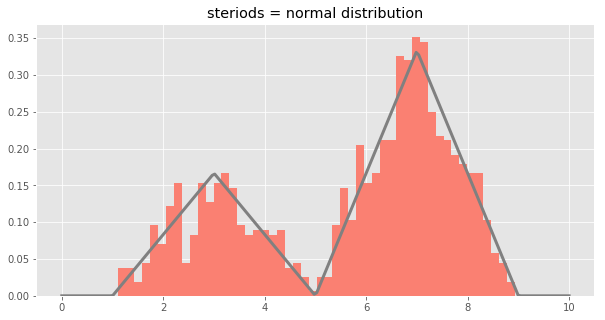

accepted:0.30  accepted samples: 1000  total sampled: 3383
E(h(X)) by rejection: 0.059155275459
E(h(X)) by importance: 0.0588994365427


In [174]:
# steriods
n_samples = 1000
accept, Eh, total= rejection(steroids, M, pdf1, n_samples, h)
Eh_im= importance(steroids, pdf1, n_samples, h)
    
fig, ax = plt.subplots(1,1,figsize = (10,5))
x = np.linspace(0, 10, 200)
ax.plot(x, pdf1(x), color='gray', linewidth=3)
ax.hist(accept, bins=50, normed=1, color='salmon', linewidth=0)
ax.set_title('steriods = normal distribution')
plt.show()
print('accepted:%0.2f'%(n_samples/total),' accepted samples:', n_samples, ' total sampled:',total)
print('E(h(X)) by rejection:',Eh)
print('E(h(X)) by importance:',Eh_im)


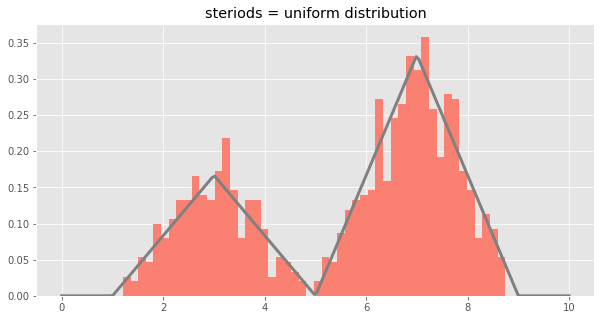

accepted:0.32  accepted samples: 1000  total sampled: 3085
E(h(X)) by rejection: 0.0589487439275
E(h(X)) by importance: 0.057993804721


In [177]:
# uniform

n_samples = 1000
accept, Eh, total = rejection(unif, M_y, pdf1, n_samples, h)
Eh_im= importance(unif, pdf1, n_samples, h)

fig, ax = plt.subplots(1,1,figsize = (10,5))
x = np.linspace(0, 10, 200)
ax.plot(x, pdf1(x), color='gray', linewidth=3)
ax.hist(accept, bins=50, normed=1, color='salmon', linewidth=0)
ax.set_title('steriods = uniform distribution')
plt.show()
print('accepted:%0.2f'%(n_samples/total),' accepted samples:', n_samples, ' total sampled:',total)
print('E(h(X)) by rejection:',Eh)
print('E(h(X)) by importance:',Eh_im)


In [157]:
#another way of defining functions

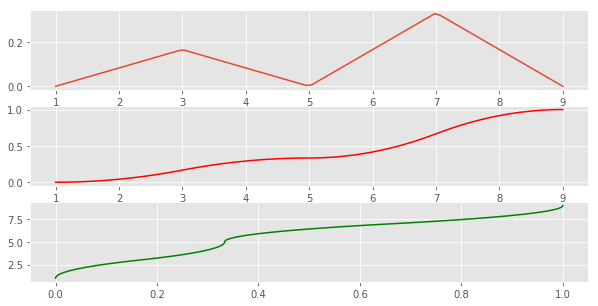

In [159]:


def h(x):
    val = np.exp(-(x-5)**2 / 18)/(3*np.sqrt(2)*np.pi)
    return val


def pdf(x):
    if(x>=1 and x<=3):
        return (x-1)/12
    elif(x>3 and x<=5):
        return -(x-5)/12
    elif(x>5 and x<=7):
        return (x-5)/6
    elif(x>7 and x<=9):
        return -(x-9)/6
    else:
        return 0
    
def cdf(x):
    
    if(x>=1 and x<=3):
        return (x-1)**2/24
    
    elif(x>3 and x<=5):
        return -(x-5)**2/24 + 1/6 + 1/6
    
    elif(x>5 and x<=7):
        return (x-5)**2/12  + 1/6 + 1/6
    
    elif(x>7 and x<=9):
        return -(x-9)**2/12 + 1/3 + 1/3 +1/6 + 1/6
    elif(x>9):
        return 1
    else:
        return 0

def invCDF(u):
    if(u>=0 and u<=1/6):
        return np.sqrt(24*u)+1

    elif(u>1/6 and u<=2/6):
        return -np.sqrt( 24*(2/6 - u) )+5
    
    elif(u>2/6 and u<= 2/3):
        return np.sqrt( 12*(u-1/3) )+5
    
    elif(u>2/3 and u<=1):
        return -np.sqrt( 12*(1-u) ) + 9


plt.figure(1)
plt.figure(figsize=(10,5))
plt.subplot(311)
xpt = np.linspace(1.,9.,100)
ypt = np.array([pdf(x) for x in xpt])
plt.plot(xpt,ypt,'-')
plt.style.use('ggplot')

plt.subplot(312)
cypt = np.array([cdf(x) for x in xpt])
#plt.figure(figsize=(10,5))
plt.plot(xpt,cypt,'r-')
plt.style.use('ggplot')

plt.subplot(313)
invypt = np.array([invCDF(u) for u in cypt])
plt.plot(cypt,invypt,'g-')
plt.style.use('ggplot')
plt.show()

## Problem 2: Variance Reduction

### Part A

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ obtained in Problem 1. Based on the discussion on sampling methods in lecture, which sampling methods, proposal distributions is expected, in principle, to resulted in lower variances? How well do your results align with these expectations?

### Part B (Stratified Sampling)

Often, a complex integral can be computed with more ease if one can break up the domain of the integral into pieces and if on each piece of the domain the integral is simplified. 

- Find a natural way to divide the domain of $X$ and express $\mathbb{E}[h(X)]$ as an ***correctly*** weighted sum of integrals over the pieces of the domain of $X$. (This constitutes the essentials of Stratified Sampling)

- Estimate each integral in the summand using rejection sampling using a normal proposal distribution (with sensibly chosen parameters). From these, estimate $\mathbb{E}[h(X)]$.

- Compute the variance of your estimate of $\mathbb{E}[h(X)]$. Compare with the variance of your previous estimate of $\mathbb{E}[h(X)]$ (in Part A, using rejection sampling, a normal proposal distribution over the entire domain of $X$).

Read more about Stratified Sampling:

1. [Variance Reduction Techniques Slides](http://www.sta.nus.edu.sg/~zhangjt/teaching/ST4231/lectures/chapter4.pdf)

2. [Monte Carlo Methods](http://www.public.iastate.edu/~mervyn/stat580/Notes/s09mc.pdf)

3. [Variance Reduction Techniques Chapter](http://sas.uwaterloo.ca/~dlmcleis/s906/chapt4.pdf)

# run each program n_sim times, to find variance and then to get error

In [186]:
n_sample = 100
n_sim    = 100

var_inv_tran = np.var([inverse_transform(h, invCDF1, n_sample)[1] for i in range(n_sim)])
var_rej_ster = np.var([rejection(h=h,n_samples=n_sample,prop_M=M,prop_pdf=steroids,true_pdf=pdf1)[1] 
                       for i in range(n_sim)])
var_rej_unif = np.var([rejection(h=h,n_samples=n_sample,prop_M=M_y,prop_pdf=unif,true_pdf=pdf1)[1] 
                       for i in range(n_sim)])
var_imp_ster = np.var([importance(h=h,n_samples=n_sample,prop_pdf=steroids,true_pdf=h)
                       for i in range(n_sim)])
var_imp_unif = np.var([importance(h=h,n_samples=n_sample,prop_pdf=unif,true_pdf=h)
                       for i in range(n_sim)])
var_list = [var_inv_tran, var_rej_ster, var_rej_unif,var_imp_ster,var_imp_unif]
var_name = ['var_inv_tran', 'var_rej_ster', 'var_rej_unif','var_imp_ster','var_imp_unif']

In [187]:
for i in range(0,len(var_list)):
    var = var_list[i]
    nam = var_name[i]
    print(nam,': ', var)

var_inv_tran :  1.05813068166e-06
var_rej_ster :  1.0925541001e-06
var_rej_unif :  1.11688591013e-06
var_imp_ster :  5.02489348037e-06
var_imp_unif :  1.27155370252e-06


# note that by visulization, the pdf of X has two parts $(-\infty,5]$ and $(5,+\infty)$

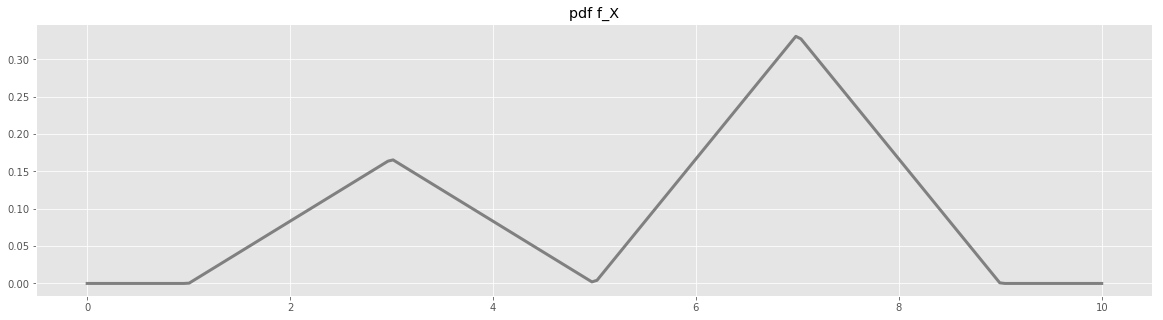

In [194]:
#visualize pdf and cdf
x = np.linspace(0, 10, 200)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(x, pdf1(x), color='gray', linewidth=3)
ax.set_title('pdf f_X')
plt.show()

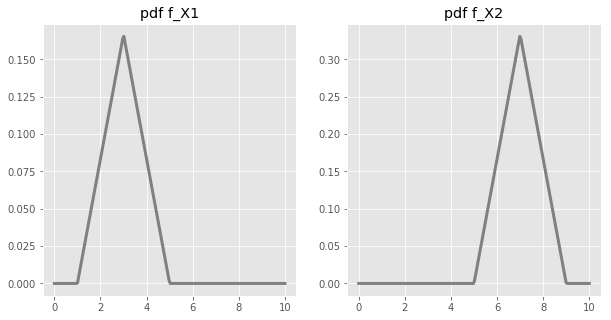

In [213]:
def pdf_s1(x):
    return pdf1(x)*(x<=5)

def pdf_s2(x):
    return pdf1(x)*(x>5)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(x, pdf_s1(x), color='gray', linewidth=3)
ax1.set_title('pdf f_X1')

ax2.plot(x, pdf_s2(x), color='gray', linewidth=3)
ax2.set_title('pdf f_X2')
plt.show()

# do rejection sampling on each piece with uniform distribution



In [ ]:
x1  = np.linspace(1-3,5+3,1000)
m1  = 3
sig1 = 1
M1   = 0.43
samples1 = steroids_prop(m1, sig1,x = x1)

x2  = np.linspace(5-3,9+3,1000)
m2  = 7
sig2 = 1
M2   = 0.9
samples2 = steroids_prop(m2, sig2,x = x2)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 5))
ax1.plot(x1, pdf_s1(x1), color='gray', linewidth=3)
ax1.plot(x1, M1*samples1, '--',color='blue')

ax2.plot(x2, pdf_s2(x2), color='gray', linewidth=3)
ax2.plot(x2, M2*samples2, '--',color='blue')
#plt.show()

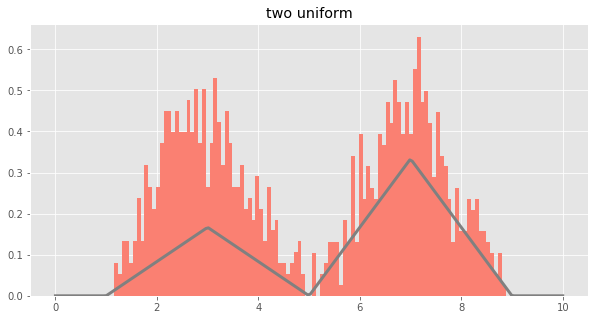

accepted:0.38  accepted samples: 500  total sampled: 1325
E(h(X)) by rejection: 0.116810528238
E(h(X)) by importance: 0.0580343340104


In [231]:
steroids1 = partial(steroids_prop, mu = m1, sigma = sig1)
steroids2 = partial(steroids_prop, mu = m2, sigma = sig2)

n_samples = 500

def h1(x):
    val = np.exp(-(x-5)**2 / 18)/(3*np.sqrt(2)*np.pi)
    return val* (x>=1) * (x<=5)

def h2(x):
    val = np.exp(-(x-5)**2 / 18)/(3*np.sqrt(2)*np.pi)
    return val* (x>5) * (x<=9)


xpt1 = np.linspace(1, 5, 50)
xpt2 = np.linspace(5, 9, 50)


accept1, Eh1, total1 = rejection(steroids1, M1, pdf_s1, n_samples, h1, lhs = 1, rhs = 5)
Eh_im1               = importance(steroids1, pdf_s1, n_samples, h)
accept2, Eh2, total2 = rejection(steroids2, M2, pdf_s2, n_samples, h2, lhs = 5, rhs = 9)
Eh_im2               = importance(steroids2, pdf_s2, n_samples, h)

Eh   = Eh1 + Eh2
Eh_im= Eh_im1 + Eh_im2
total= total1 + total2

fig, ax = plt.subplots(1,1,figsize = (10,5))
x = np.linspace(0, 10, 200)
ax.plot(x, pdf1(x), color='gray', linewidth=3)
ax.hist(accept1, bins=50, normed=1, color='salmon', linewidth=0)
ax.hist(accept2, bins=50, normed=1, color='salmon', linewidth=0)

ax.set_title('two uniform')

plt.show()
print('accepted:%0.2f'%(n_samples/total),' accepted samples:', n_samples, ' total sampled:',total)
print('E(h(X)) by rejection:',Eh)
print('E(h(X)) by importance:',Eh_im)

In [234]:
print(Eh2)

0.0590334055445
